## Customer churn challenge

In [1]:
import pandas as pd
import seaborn as sns
import pylab as plt
import numpy as np, numpy.random
import markov

sns.set(palette= 'coolwarm', style= 'darkgrid')
sns.set_context("notebook",font_scale=1.5, rc={"lines.linewidth": 2.5, 'figure.figsize':(13.0,8.27)})

In [2]:
prices = pd.read_excel('prices.xlsx')

In [3]:
sales= pd.read_excel('sales_data.xlsx')

### Merge Price and Sales Tables

In [4]:
new_df = pd.merge(sales, prices,  how='left', left_on=['flavor','market'], right_on = ['flavor','market'])

In [5]:
new_df['date'] = pd.to_datetime(new_df['date'])
new_df['year']= new_df.date.dt.year

### 1. The business wants to know the revenue over time for each market and each flavor. Prepare a set of meaningful and readable plots.

#### Show revenue per Market

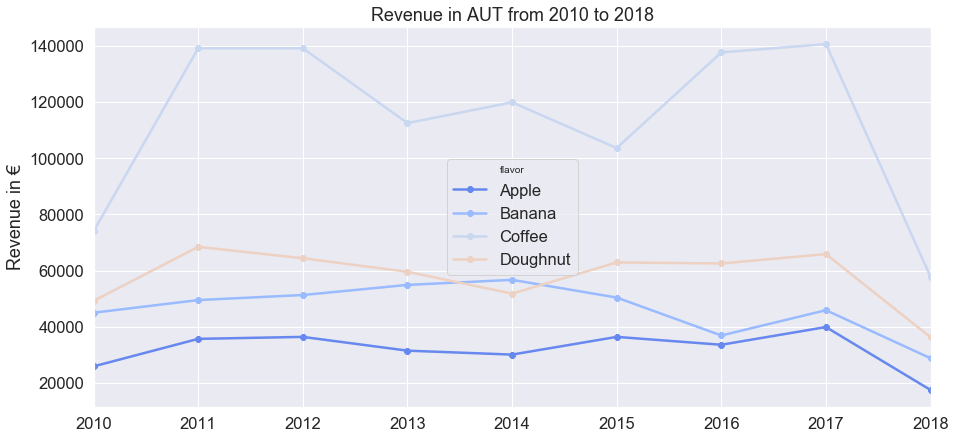

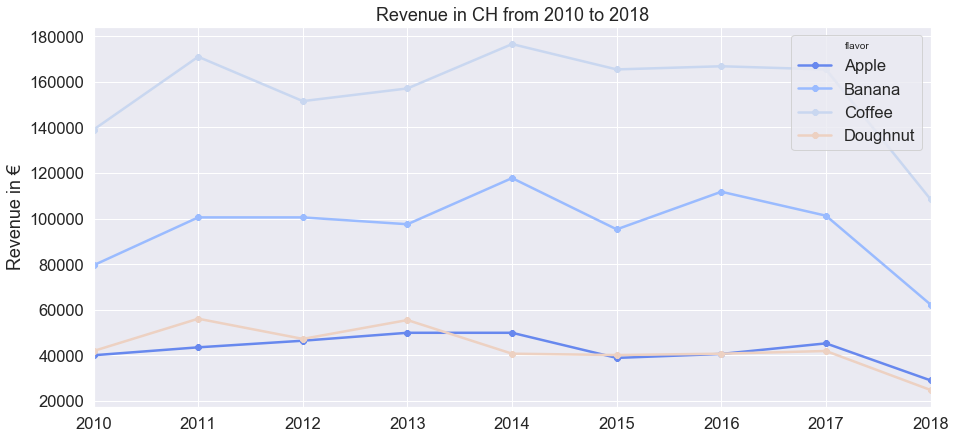

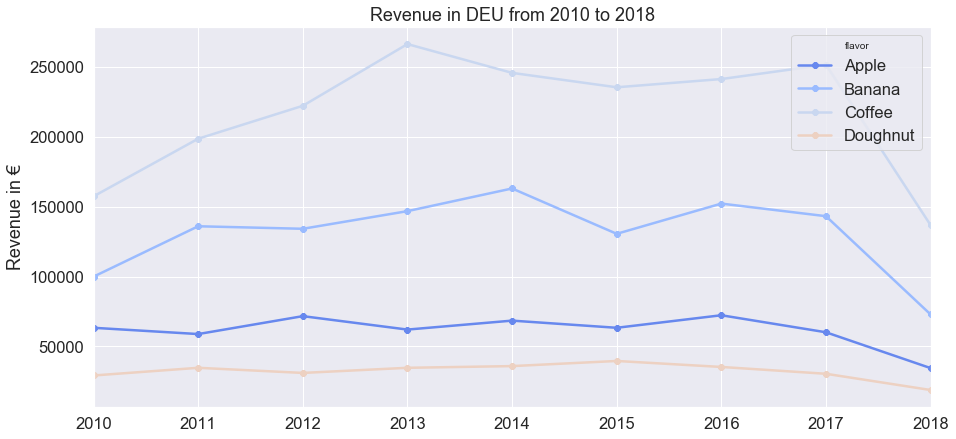

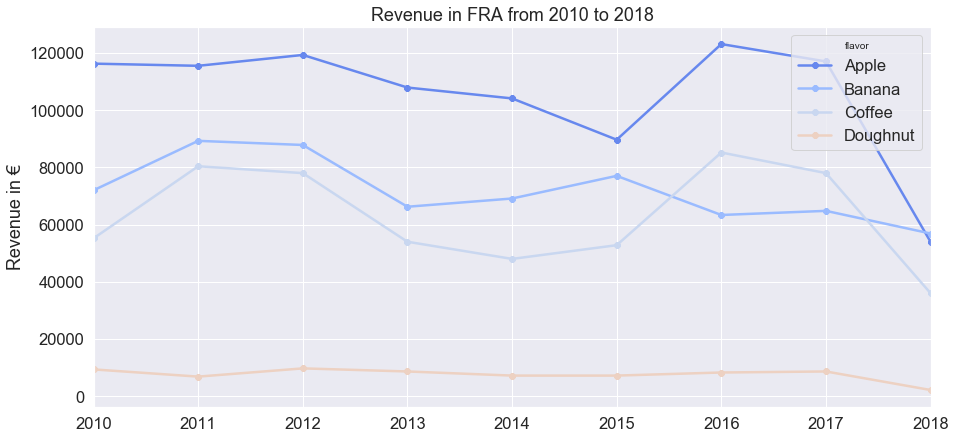

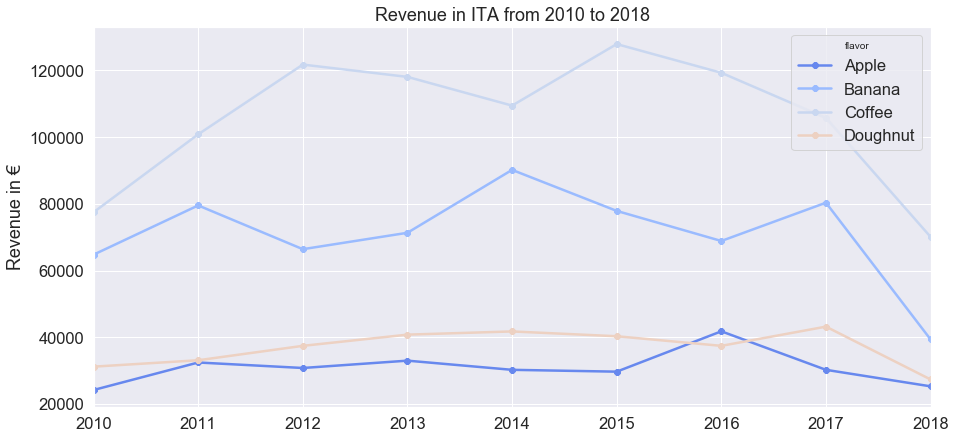

In [6]:
for market in new_df.market.unique():
    new_df.loc[new_df.market== market].groupby(['year','flavor'])['price'].sum().unstack(1).plot(figsize=(15,7), marker="8")
    plt.title('Revenue in {mark} from 2010 to 2018'.format(mark= market))
    plt.xlabel("")
    plt.ylabel("Revenue in €")

### 2. Create a plot that breaks down the average revenue per customer for each country and shows which flavor contributes how much to that revenue.

In [ ]:
new_df.groupby(['flavor', 'customer_id', 'market'])['price'].sum().unstack(0)\
.groupby('market').mean().plot(kind= "bar", stacked= True, figsize= (15,7))
plt.title('Average revenue per customer and market and flavor')
plt.xlabel('')
plt.ylabel('revenue in €')

In [ ]:
cust_rev = new_df.groupby(['market', 'flavor']).agg({'customer_id':'nunique', 'price': 'sum'}).rename(columns={'customer_id':'nr_of_customers', 'price': 'total_revenue'})
cust_rev['revenue_per_cust'] = cust_rev.total_revenue/cust_rev.nr_of_customers

### 3. Flavor preference in first vs. following purchase

In [7]:
three= new_df.sort_values(by= ['customer_id', 'date'])

In [8]:
three['cust1']= three.customer_id.shift()

In [9]:
three['fir']= ["following" if three.customer_id[i]== three.cust1[i] else "first" for i in three.index]

#### Create plots per market

In [ ]:
for market in three.market.unique():
    three.loc[three.market== market].groupby(['flavor', 'fir'])['flavor'].count()\
    .unstack(0).plot(kind= "bar", stacked= False, figsize= (15,7))
    plt.title('First vs following purchases in {mark}'.format(mark= market))
    plt.xlabel("")

### 4. First versus following purchases in CLR

Create a plot showing average revenue by customer. Break it down by market and by the contribution of the first purchase versus the contribution of all following purchases to the average revenue.

In [10]:
four = three.groupby(['market', 'fir']).agg({'customer_id':'nunique', 'price': 'sum'})\
.rename(columns={'customer_id':'nr_of_customers', 'price': 'total_revenue'})

four['first_rev'] = four.total_revenue/four.groupby('market').nr_of_customers.max()

#### Create plot showing average revenue for first vs. following purchase per market

In [ ]:
four.groupby(['market', 'fir'])['first_rev'].mean().unstack(1).plot(kind= "barh", stacked= True, figsize= (15,7))
plt.title('Average revenue per first vs. following purchase')
plt.ylabel('')
plt.xlabel('revenue in €')

### 5 – Transitions

We want to analyse how people switch between flavors. Visualise the probability of flavor
transitions, i.e. of a customer buying flavor B after buying flavor A for all pairs of flavors. If a
customer’s last purchase has occurred more than 6 months before the latest date in the dataset,
we consider him as “churned”, and we record a transition from his last flavor to a special state
called “churned”.

In [11]:
five= three


In [12]:
def is_churned(df):
    """Detects churned customers in dataframe containing datetime and customer_id column
    --> Churnday= Critical date --> in this case 6 months before last purchase
    """
    churnday= df.date.max()- pd.Timedelta('0.5 Y')
    df['cust_after']= df.customer_id.shift(-1)
    chur= []
    for i,row in df.iterrows():
        if row.customer_id != row.cust_after and row.date < churnday:
            chur.append('Churned')
        elif row.customer_id == row.cust_after:
            chur.append('Not_last')
        else:
            chur.append('Active')
    return chur

In [13]:
def get_transition(df):
    """ Assigns next state (e.g. 'Churned') to list based on first and following purchases"""
    df['flavor_after']= df.flavor.shift(-1)
    trans_col= []
    for i,row in df.iterrows():  
        if row.churned == 'Not_last':
            trans_col.append(row.flavor_after)
        elif row.churned== 'Churned':
            trans_col.append('Churned')
        else:
            trans_col.append('other')
            
    return trans_col

In [14]:
five['churned']= is_churned(five)
five['trans']= get_transition(five)

In [15]:
pmatrix= five[five.trans!= 'other'].groupby(['flavor', 'trans'])['trans'].count().unstack(1)
pmatrix=pmatrix[['Apple', 'Banana', 'Coffee', 'Doughnut', 'Churned']]

In [16]:
tmatrix= pmatrix.div((pmatrix.sum(axis=1)), axis= 'rows')

In [ ]:
tmatrix.plot(kind= "bar", stacked= False, figsize= (15,7))
plt.xlabel("")

## Markov Chain simulation

In [17]:
tmatrix.loc['Churned']= [0.0,0.0,0.0,0.0, 1.0]

In [18]:
state_list = pd.Series(np.array([100,100,100,100,0]),index=['Apple','Banana','Coffee','Dougnut','Churned'])

### Define Markow Chain Class

In [ ]:
import markov

In [ ]:
babbel= markov.MarkovChain(tmatrix= tmatrix, states= ['Apple', 'Banana', 'Coffee', 'Doughnut', 'Churned'])

In [ ]:
babbel.generate_states(current_state= 'Banana', step_nr= 3)

In [ ]:
market_price= new_df.groupby(['market','flavor'])['price'].mean().unstack(1)
market_price['Churned']= [0 for i in market_price.index]

In [ ]:
df= babbel.cust_nr(state_list, step_nr=20, new_quote=0.75)

In [ ]:
df

In [ ]:
df_price= babbel.get_clv('AUT', market_price, state_list, step_nr=10)

In [ ]:
df.plot(figsize=(15,7), marker="8", ylim= (0,1000))
plt.ylabel('Customer State')
plt.xlabel('Timesteps')

### Plot customer lifetime revenue per market

In [ ]:
for market in market_price.index:
    df_price.plot(figsize= (15,7), marker= "8")
    plt.ylabel('Customer Revenue in €')
    plt.xlabel('Timesteps')
    plt.title('Revenue in {mark} over time'.format(mark= market))

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
df_price.values

In [ ]:
init_state= np.array(state_list)

In [19]:
import test_3 as test

In [20]:
babbel= test.MarkovChain(tmatrix= tmatrix, states= ['Apple', 'Banana', 'Coffee', 'Doughnut', 'Churned'])

In [21]:
df= babbel.cust_nr_churned(state_list, step_nr=20, new_quote=0.75)

AssertionError: 5 columns passed, passed data had 20 columns

In [ ]:
cust_nr_churn(state_list, 10, 0.75)